# Code for getting Exoplanets w Unknown orbital parameters from FFIs

# How to use
Search a single target from FFI:
* results = ffi_planet_search('TIC 307210830')

Or just extract light curve:
* lc = extract_lightcurve_from_ffi('TIC 307210830')

Batch search:
* tic_list = [307210830, 141914082, 231670397]
* df, results = batch_ffi_search(tic_list)


Initial imports

In [1]:
import os
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"

import lightkurve as lk
from astropy.timeseries import BoxLeastSquares
from astroquery.mast import Catalogs
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

C:\Users\Coral14\Documents\TESS-Exoplanet\tess-env\Lib\site-packages\lightkurve\prf\__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
C:\Users\Coral14\AppData\Local\Temp\ipykernel_15636\2272589985.py:7: DeprecationWarning: the ``nasa_exoplanet_archive`` module has been moved to astroquery.ipac.nexsci.nasa_exoplanet_archive, please update your imports.
  from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive


# Extracting Light Curve from FFI
* downloads FFI data from TESS
* cuts out small region around target star
* uses apterature photometry to create light curve

In [2]:
def extract_lightcurve_from_ffi(target, sector=None, cutout_size=15, 
                                 aperture_radius=1, quality_bitmask='default'):
    """
    Extract a light curve from TESS Full Frame Images (FFIs).
    """
    
    # Convert numpy int to Python int
    if isinstance(target, (int, np.integer)):
        target = int(target)
        target = f"TIC {target}"
    
    print(f"Extracting FFI light curve for {target}")
    print("This may take awhile")
    
    try:
        # Search for FFI data
        print("  Searching for FFI data...")
        search_result = lk.search_tesscut(target)
        
        if len(search_result) == 0:
            print(f"    No FFI data found")
            return None
        
        if sector is not None:
            search_result = search_result[search_result.mission == f'TESS Sector {sector}']
            if len(search_result) == 0:
                print(f"    No data in sector {sector}")
                return None
        
        print(f"    Found FFI data in {len(search_result)} sector(s)")
        
        # Download FFI cutouts
        print(f"  Downloading {cutout_size}x{cutout_size} pixel cutouts...")
        tpf_collection = search_result.download_all(cutout_size=cutout_size)
        
        if tpf_collection is None or len(tpf_collection) == 0:
            print("    Download failed")
            return None
        
        # Extract light curves from each sector
        lc_list = []
        
        for tpf in tpf_collection:
            try:
                print(f"  Processing Sector {tpf.sector}...")
                
                # BETTER APERTURE SELECTION
                # Try different thresholds and pick the most reasonable one
                aperture_mask = None
                
                # Try threshold 5 first (more selective)
                test_mask = tpf.create_threshold_mask(threshold=5, reference_pixel='center')
                if 5 <= test_mask.sum() <= 25:  # Reasonable size
                    aperture_mask = test_mask
                    print(f"    Using threshold=5 mask")
                
                # If that didn't work, try threshold 3
                if aperture_mask is None:
                    test_mask = tpf.create_threshold_mask(threshold=3, reference_pixel='center')
                    if 5 <= test_mask.sum() <= 30:
                        aperture_mask = test_mask
                        print(f"    Using threshold=3 mask")
                
                # If still nothing, use small circular aperture
                if aperture_mask is None or aperture_mask.sum() == 0:
                    print("    Using small circular aperture (r=2 pixels)")
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= 2:
                                aperture_mask[i, j] = True
                
                print(f"    Aperture size: {aperture_mask.sum()} pixels")
                
                # If aperture is still too large, force smaller
                if aperture_mask.sum() > 30:
                    print(f"    WARNING: Aperture too large ({aperture_mask.sum()}), forcing r=1.5")
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= 1.5:
                                aperture_mask[i, j] = True
                    print(f"    Reduced to {aperture_mask.sum()} pixels")
                
                # Perform aperture photometry
                lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
                
                # Quality filtering
                lc = lc[lc.quality == 0]
                lc = lc.remove_nans()
                
                # Remove extreme outliers BEFORE appending
                lc = lc.remove_outliers(sigma=10)
                
                if len(lc) < 100:
                    print(f"      Too few data points ({len(lc)})")
                    continue
                
                print(f"      Extracted {len(lc)} data points")
                lc_list.append(lc)
                
            except Exception as e:
                print(f"      Error in Sector {tpf.sector}: {e}")
                continue
        
        if len(lc_list) == 0:
            print("    No valid light curves extracted")
            return None
        
        # Stitch light curves together
        print(f"\n  Stitching {len(lc_list)} sector(s) together...")
        combined_lc = lc_list[0]
        for lc in lc_list[1:]:
            combined_lc = combined_lc.append(lc)
        
        # Normalize
        combined_lc = combined_lc.normalize()
        
        # Remove any remaining extreme outliers
        combined_lc = combined_lc.remove_outliers(sigma=7)
        
        print(f"    Final: {len(combined_lc)} points, {combined_lc.time[-1].value - combined_lc.time[0].value:.1f} day baseline")
        
        return combined_lc
        
    except Exception as e:
        print(f"    Extraction failed: {e}")
        return None

# Search for planet from FFI Light Curve
# (this is when period unknown)
* takes extracted FFI light curve and runs Boxed Least Squared to find periodic transit signals
* cleans/detrends
* create plot
* if found, returns planet parameters

In [3]:
def search_for_planets_in_ffi(lightcurve, period_min=0.5, period_max=30, 
                               detrend=True, plot=True):
    """
    Search for exoplanet transits in an FFI-derived light curve using Boxed Least Squares (BLS)
    
    period_min, period_max(float)
        in days
    detrend(bool)
        whether to flatten/detrend  light curve
    plot(bool)
        Whether to create diagnostic plots, t/f
    """
    
    print("\n" + "="*20)
    print("Looking for Transits")
    print("="*20)
    
    lc = lightcurve.copy()
    
    # Detrending and cleaning
    if detrend:
        print("Detrending light curve...")
        
        # Remove outliers before flattening
        lc = lc.remove_outliers(sigma=5)
        
        # Flatten to remove stellar variability
        # Window length depends on minimum period (making it 2.5 times as long here, can change)
        # *also* convert to number of cadences (not days)
        median_cadence = np.median(np.diff(lc.time.value))  # days
        window_length_days = max(1.0, period_min * 2.5)  # days
        window_length_cadences = int(window_length_days / median_cadence) # convert to number of candences
        
        # Must be odd number
        if window_length_cadences % 2 == 0:
            window_length_cadences += 1
        
        # Ensure reasonable range
        window_length_cadences = max(51, min(window_length_cadences, len(lc) // 3))
        
        print(f"  Flattening with window = {window_length_cadences} cadences ({window_length_cadences * median_cadence:.1f} days)")
        lc = lc.flatten(window_length=window_length_cadences)
        
        # Remove outliers again after flattening
        lc = lc.remove_outliers(sigma=4)
        
        # Sigma clipping
        flux_median = np.median(lc.flux.value)
        flux_std = np.std(lc.flux.value)
        mask_good = np.abs(lc.flux.value - flux_median) < 4 * flux_std
        lc = lc[mask_good]
        
        print(f"  After cleaning: {len(lc)} points")
    
    if len(lc) < 500:
        print("  Too few points after cleaning")
        return None
    
    # Prepare data for BLS
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value
    
    # Run BLS --> this is where detect planet
    print(f"Running BLS (searching periods {period_min:.1f} - {period_max:.1f} days)...")
    
    model = BoxLeastSquares(time, flux, flux_err)
    
    # Create period grid (denser for better accuracy)
    periods = np.linspace(period_min, period_max, 10000)
    
    # Duration grid (0.5 hours to 8 hours)
    durations = np.linspace(0.02, 0.33, 15)  # in days
    
    # Compute periodogram
    bls_result = model.power(periods, durations)
    
    # Extract best result
    best_idx = np.argmax(bls_result.power)
    
    results = {
        'period': bls_result.period[best_idx],
        'duration': bls_result.duration[best_idx],
        't0': bls_result.transit_time[best_idx],
        'depth': bls_result.depth[best_idx],
        'depth_ppm': bls_result.depth[best_idx] * 1e6,
        'power': bls_result.power[best_idx],
        'snr': bls_result.depth[best_idx] / bls_result.depth_err[best_idx],
        'n_transits': int((time[-1] - time[0]) / bls_result.period[best_idx]),
        'lightcurve': lc,
        'bls_result': bls_result
    }
    
    print("\nBLS RESULTS:")
    print(f"  Period: {results['period']:.4f} days")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Transit depth: {results['depth_ppm']:.1f} ppm ({results['depth']*100:.3f}%)")
    print(f"  BLS Power: {results['power']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    print(f"  Expected transits: {results['n_transits']}")
    
    # Plotting
    if plot:
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Full light curve
        ax1 = plt.subplot(3, 2, 1)
        lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
        ax1.set_title('(Cleaned) FFI Light Curve', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time [BTJD]')
        ax1.set_ylabel('Normalized Flux')
        
        # 2. BLS Periodogram
        ax2 = plt.subplot(3, 2, 2)
        ax2.plot(bls_result.period, bls_result.power, 'k-', lw=0.5)
        ax2.axvline(results['period'], color='red', ls='--', lw=2, 
                    label=f"Best Period = {results['period']:.3f} d")
        ax2.set_xlabel('Period (days)')
        ax2.set_ylabel('BLS Power')
        ax2.set_title('BLS Periodogram', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Folded light curve (all points)
        ax3 = plt.subplot(3, 2, 3)
        lc_folded = lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_folded.scatter(ax=ax3, s=1, c='black', alpha=0.3)
        ax3.set_title(f"Folded Light Curve (P={results['period']:.4f} d)", 
                     fontsize=14, fontweight='bold')
        ax3.set_xlabel('Phase')
        ax3.set_ylabel('Normalized Flux')
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)
        
        # 4. Binned folded light curve
        ax4 = plt.subplot(3, 2, 4)
        lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
        lc_folded_binned.scatter(ax=ax4, s=20, c='red')
        ax4.set_title(f"Binned Transit (Depth={results['depth_ppm']:.1f} ppm)", 
                     fontsize=14, fontweight='bold')
        ax4.set_xlabel('Phase')
        ax4.set_ylabel('Normalized Flux')
        ax4.axvline(0, color='red', ls='--', alpha=0.5)
        ax4.grid(alpha=0.3)
        
        # 5. Individual transits
        ax5 = plt.subplot(3, 2, 5)
        transit_times = results['t0'] + results['period'] * np.arange(-10, 100)
        transit_times = transit_times[(transit_times >= time[0]) & (transit_times <= time[-1])]
        
        ax5.plot(time, flux, 'k.', ms=1, alpha=0.5)
        for tt in transit_times:
            ax5.axvline(tt, color='red', alpha=0.3, lw=1)
        ax5.set_xlabel('Time [BTJD]')
        ax5.set_ylabel('Normalized Flux')
        ax5.set_title(f'Predicted Transit Times (n={len(transit_times)})', 
                     fontsize=14, fontweight='bold')
        
        # 6. Zoomed transit
        ax6 = plt.subplot(3, 2, 6)
        if len(transit_times) > 0:
            # Zoom to first transit
            first_transit = transit_times[0]
            transit_window = results['duration'] * 3
            mask_zoom = (time > first_transit - transit_window) & (time < first_transit + transit_window)
            
            if mask_zoom.sum() > 0:
                ax6.plot(time[mask_zoom], flux[mask_zoom], 'ko', ms=3)
                ax6.axvline(first_transit, color='red', ls='--', alpha=0.5)
                ax6.set_xlabel('Time [BTJD]')
                ax6.set_ylabel('Normalized Flux')
                ax6.set_title('First Transit (Zoomed)', fontsize=14, fontweight='bold')
                ax6.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

# Check detected light curves from FFI data
* checks if planet candidates are real

In [4]:
def vet_ffi_detection(results):
    """
    Check a planet candidate from FFI data.
    FFI has different characteristics than 2-min cadence data.
    """
    
    period = results['period']
    depth_ppm = results['depth_ppm']
    duration_hrs = results['duration'] * 24
    power = results['power']
    snr = results.get('snr', 0)
    n_transits = results.get('n_transits', 0)

    # Assume good to start
    verdict = "GOOD"
    reasons = []
    
    # 1. Check period
    if period < 0.5:
        verdict = "BAD"
        reasons.append(f"Period too short ({period:.2f}d) - likely noise or systematics")
    
    # Check for FFI cadence artifacts (30 min = 0.0208 days)
    ffi_cadence = 0.0208
    for mult in range(1, 10):
        if abs(period - mult * ffi_cadence) < 0.002:
            verdict = "BAD"
            reasons.append(f"Period matches FFI cadence artifact ({mult}×30min)")
            break
    
    # Check for sector length artifacts
    sector_length = 27.4
    for mult in [1, 2, 3]:
        if abs(period - mult * sector_length) < 2.0:
            verdict = "BAD"
            reasons.append(f"Period matches sector artifact ({mult}×27.4d)")
            break
    
    # 2. Check depth
    if depth_ppm > 50000:  # >5%
        verdict = "BAD"
        reasons.append(f"Depth too large ({depth_ppm:.0f} ppm) - likely eclipsing binary")
    
    if depth_ppm < 50:  # <50 ppm
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Very shallow ({depth_ppm:.0f} ppm) - hard to detect in FFI")
    
    # 3. Duration checks
    if duration_hrs < 0.5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Short duration ({duration_hrs:.1f}h) - near FFI time resolution")
    
    if duration_hrs > 12:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Long duration ({duration_hrs:.1f}h) - unusual")
    
    # 4. Check SNR and power 
    if power < 50:
        verdict = "BAD"
        reasons.append(f"Low BLS power ({power:.0f}) - weak signal")
    
    if snr < 5:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Low SNR ({snr:.1f}) - needs confirmation")
    
    # 5. Count transits
    if n_transits < 3:
        if verdict != "BAD":
            verdict = "SUSPICIOUS"
        reasons.append(f"Only {n_transits} transits - needs more data")
    
    # If no issues found --> good
    if len(reasons) == 0:
        reasons.append(f"Passes all checks: P={period:.2f}d, depth={depth_ppm:.0f}ppm, {n_transits} transits")
    
    return verdict, reasons

# Prints vetting results

In [5]:
def print_ffi_vet_result(target, results):
    """Print vetting results for FFI detection"""
    verdict, reasons = vet_ffi_detection(results)
    
    print("\n" + "="*70)
    print("VETTING RESULTS")
    print("="*70)
    
    if verdict == "GOOD":
        print(f"  {target}: GOOD CANDIDATE")
    elif verdict == "SUSPICIOUS":
        print(f"  {target}: SUSPICIOUS - NEEDS REVIEW")
    else:
        print(f"  {target}: LIKELY FALSE POSITIVE")
    
    print("\nReasons:")
    for reason in reasons:
        print(f"  • {reason}")
    print("="*20)

# Complete Planet Search
Using functions from above (extract_lightcurve_from_ffi() and search_for_planets_in_ffi())
* also checks detection

In [6]:
def ffi_planet_search(target, period_min=0.5, period_max=30, 
                      cutout_size=15, plot=True):
    """
    Extract FFI light curve → Search for planets → Vet
    
    Parameters:
    -----------
    target(str/int)
        (TIC ID or name)
    period_min, period_max(float)
        in days
    cutout_size(int)
        FFI cutout size in pixels
    plot(bool)
        Create diagnostic plots
    """
    
    print("\n" + "="*20)
    print(f"FFI EXOPLANET SEARCH: {target}")
    print("="*20)
    
    # Step 1: Extract light curve from FFI
    lc = extract_lightcurve_from_ffi(target, cutout_size=cutout_size)
    
    if lc is None:
        print("\n  Failed to extract light curve")
        return None
    
    # Step 2: Search for planets
    results = search_for_planets_in_ffi(lc, period_min=period_min, 
                                         period_max=period_max, plot=plot)
    
    if results is None:
        print("\n  Planet search failed")
        return None
    
    # Step 3: Vet the detection
    print_ffi_vet_result(target, results)
    
    return results

# Search multiple stars at once from FFI data

In [7]:
def batch_ffi_search(tic_ids, period_min=0.5, period_max=30, 
                     save_results=True):
    
    all_results = []
    
    print("\n" + "="*20)
    print(f"BATCH FFI SEARCH: {len(tic_ids)} TARGETS")
    print("="*20)
    
    for i, tic_id in enumerate(tic_ids, 1):
        print(f"\n[{i}/{len(tic_ids)}] Processing TIC {tic_id}...")
        
        try:
            result = ffi_planet_search(tic_id, period_min=period_min, 
                                       period_max=period_max, plot=False)
            
            if result is not None:
                verdict, _ = vet_ffi_detection(result)
                result['verdict'] = verdict
                result['tic_id'] = tic_id
                all_results.append(result)
                
        except Exception as e:
            print(f"✗ Error processing TIC {tic_id}: {e}")
    
    # Summary
    if len(all_results) > 0:
        # Remove non-serializable objects for DataFrame
        df_results = []
        for r in all_results:
            df_results.append({
                'tic_id': r['tic_id'],
                'period': r['period'],
                'depth_ppm': r['depth_ppm'],
                'duration_hrs': r['duration'] * 24,
                'power': r['power'],
                'snr': r['snr'],
                'n_transits': r['n_transits'],
                'verdict': r['verdict']
            })
        
        df = pd.DataFrame(df_results)
        df = df.sort_values('power', ascending=False)
        
        print("\n" + "="*20)
        print("Finished Batch Search")
        print("="*20)
        print(f"\nSuccessfully analyzed: {len(df)} targets\n")
        print(df.to_string(index=False))
        
        n_good = (df['verdict'] == 'GOOD').sum()
        n_susp = (df['verdict'] == 'SUSPICIOUS').sum()
        n_bad = (df['verdict'] == 'BAD').sum()
        
        print(f"\nSUMMARY:")
        print(f"     Good: {n_good}")
        print(f"     Suspicious: {n_susp}")
        print(f"     False positives: {n_bad}")
        
        if save_results:
            df.to_csv('ffi_planet_search_results.csv', index=False)
            print(f"\nResults saved to ffi_planet_search_results.csv")
        
        return df, all_results  # Returns both DataFrame and full results
    
    return None, None

# Searching Exoplanets with known period (via BLS) but unknown planet radius
* uses BLS to analyze light curve
* gives better period (we calculate our own periold via BLS), transit depth to derive radius
* (later) can use batman to fit transit model to get mass, eccentricity, etc

In [8]:
def search_tois_with_missing_params():
    """
    Find TOIs with missing orbital parameters
    """
    print("=" * 20)
    print("SEARCHING FOR TOIs WITH MISSING ORBITAL PARAMETERS")
    print("=" * 20)
    
    try:
        # Check TOI table
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_orbpererr1, pl_rade, pl_radeerr1, st_tmag"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid'])
        df['tic_id'] = df['tid'].astype(int)
        
        # Filter for TOIs with MISSING or UNCERTAIN parameters
        missing_params = df[
            # Has period (transit detected)
            (df['pl_orbper'].notna()) &
            (
                # BUT missing radius
                (df['pl_rade'].isna()) |
                # OR radius uncertain (>20% error)
                (
                    (df['pl_radeerr1'].notna()) & 
                    (df['pl_rade'].notna()) & 
                    ((df['pl_radeerr1'] / df['pl_rade']) > 0.2)
                ) |
                # OR period uncertain (>5% error)
                (
                    (df['pl_orbpererr1'].notna()) & 
                    ((df['pl_orbpererr1'] / df['pl_orbper']) > 0.05)
                )
            )
        ]
        
        # Sort by brightness
        missing_params = missing_params.sort_values('st_tmag')
        
        print(f"\nFound {len(missing_params)} TOIs with incomplete/uncertain parameters")
        
        # Count different categories
        n_missing_radius = missing_params['pl_rade'].isna().sum()
        
        n_uncertain_radius = 0
        if 'pl_radeerr1' in missing_params.columns:
            uncertain_mask = (
                (missing_params['pl_radeerr1'].notna()) & 
                (missing_params['pl_rade'].notna()) & 
                ((missing_params['pl_radeerr1'] / missing_params['pl_rade']) > 0.2)
            )
            n_uncertain_radius = uncertain_mask.sum()
        
        n_uncertain_period = 0
        if 'pl_orbpererr1' in missing_params.columns:
            uncertain_per_mask = (
                (missing_params['pl_orbpererr1'].notna()) & 
                ((missing_params['pl_orbpererr1'] / missing_params['pl_orbper']) > 0.05)
            )
            n_uncertain_period = uncertain_per_mask.sum()
        
        print("\nCategories:")
        print(f"  - Missing radius: {n_missing_radius}")
        print(f"  - Uncertain radius (>20% error): {n_uncertain_radius}")
        print(f"  - Uncertain period (>5% error): {n_uncertain_period}")

        # gets top 20 candidates, can change later
        print("\nTop 20 candidates (brightest stars):")
        display_cols = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        print(missing_params[display_cols].head(20).to_string(index=False))
        
        return missing_params
        
    except Exception as e:
        print(f"Error: {e}")
        return None

# Updated search

In [13]:
def search_for_planets_in_ffi_constrained(lightcurve, known_period=None, 
                                           period_min=0.5, period_max=30, 
                                           detrend=True, plot=True):
    """
    Search for transits with optional period constraint.
    If known_period is provided, searches tightly around it.
    """
    
    print("\n" + "="*20)
    print("Looking for Transits")
    print("="*20)
    
    lc = lightcurve.copy()
    
    # Detrending
    if detrend:
        print("Detrending light curve...")
        lc = lc.remove_outliers(sigma=5)
        
        median_cadence = np.median(np.diff(lc.time.value))
        
        # If we know the period, use longer window to preserve transit
        if known_period is not None:
            window_length_days = max(2.0, known_period * 3)  # 3x period
            print(f"  Using known period {known_period:.2f}d to set window")
        else:
            window_length_days = max(1.0, period_min * 2.5)
        
        window_length_cadences = int(window_length_days / median_cadence)
        
        if window_length_cadences % 2 == 0:
            window_length_cadences += 1
        
        window_length_cadences = max(51, min(window_length_cadences, len(lc) // 3))
        
        print(f"  Flattening with window = {window_length_cadences} cadences")
        lc = lc.flatten(window_length=window_length_cadences)
        lc = lc.remove_outliers(sigma=4)
        
        flux_median = np.median(lc.flux.value)
        flux_std = np.std(lc.flux.value)
        mask_good = np.abs(lc.flux.value - flux_median) < 4 * flux_std
        lc = lc[mask_good]
        
        print(f"  After cleaning: {len(lc)} points")
    
    if len(lc) < 500:
        print("  Too few points after cleaning")
        return None
    
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value
    
    # Adjust period search range if we have a known period
    if known_period is not None:
        # Search +/- 20% around known period
        period_min = known_period * 0.8
        period_max = known_period * 1.2
        print(f"Constrained search: {period_min:.2f} - {period_max:.2f} days (±20% of {known_period:.2f}d)")
    else:
        print(f"Unconstrained search: {period_min:.1f} - {period_max:.1f} days")
    
    model = BoxLeastSquares(time, flux, flux_err)
    periods = np.linspace(period_min, period_max, 10000)
    durations = np.linspace(0.02, 0.33, 15)
    
    bls_result = model.power(periods, durations)
    
    best_idx = np.argmax(bls_result.power)
    
    results = {
        'period': bls_result.period[best_idx],
        'duration': bls_result.duration[best_idx],
        't0': bls_result.transit_time[best_idx],
        'depth': bls_result.depth[best_idx],
        'depth_ppm': bls_result.depth[best_idx] * 1e6,
        'power': bls_result.power[best_idx],
        'snr': bls_result.depth[best_idx] / bls_result.depth_err[best_idx],
        'n_transits': int((time[-1] - time[0]) / bls_result.period[best_idx]),
        'lightcurve': lc,
        'bls_result': bls_result,
        'known_period': known_period
    }
    
    print("\nBLS RESULTS:")
    print(f"  Period: {results['period']:.4f} days (red line on top right)")
    if known_period is not None:
        diff = abs(results['period'] - known_period)
        pct_diff = (diff / known_period) * 100
        print(f"  Known:  {known_period:.4f} days (diff: {pct_diff:.1f}%)")
    print(f"  Duration: {results['duration']*24:.2f} hours")
    print(f"  Depth: {results['depth_ppm']:.1f} ppm")
    print(f"  Power: {results['power']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    
    # [Keep same plotting code as before]
    if plot:
        fig = plt.figure(figsize=(16, 12))
        
        ax1 = plt.subplot(3, 2, 1)
        lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
        ax1.set_title('FFI Light Curve', fontsize=14, fontweight='bold')
        
        ax2 = plt.subplot(3, 2, 2)
        ax2.plot(bls_result.period, bls_result.power, 'k-', lw=0.5)
        ax2.axvline(results['period'], color='red', ls='--', lw=2, 
                    label=f"BLS: {results['period']:.3f} d")
        if known_period is not None:
            ax2.axvline(known_period, color='blue', ls='--', lw=2, alpha=0.5,
                       label=f"Catalog: {known_period:.3f} d")
        ax2.set_xlabel('Period [days]')
        ax2.set_ylabel('BLS Power')
        ax2.set_title('BLS Periodogram', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        ax3 = plt.subplot(3, 2, 3)
        lc_folded = lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_folded.scatter(ax=ax3, s=1, c='black', alpha=0.3)
        ax3.set_title(f"Folded at BLS Period", fontsize=14, fontweight='bold')
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)
        
        ax4 = plt.subplot(3, 2, 4)
        lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
        lc_folded_binned.scatter(ax=ax4, s=20, c='red')
        ax4.set_title(f"Binned (Depth={results['depth_ppm']:.1f} ppm)", fontsize=14, fontweight='bold')
        ax4.axvline(0, color='red', ls='--', alpha=0.5)
        ax4.grid(alpha=0.3)
        
        # If we have known period, also show folded at that period
        if known_period is not None:
            ax5 = plt.subplot(3, 2, 5)
            lc_folded_known = lc.fold(period=known_period)
            lc_folded_known.scatter(ax=ax5, s=1, c='blue', alpha=0.3)
            ax5.set_title(f"Folded at Catalog Period ({known_period:.3f}d)", 
                         fontsize=14, fontweight='bold')
            ax5.axvline(0, color='blue', ls='--', alpha=0.5)
            ax5.grid(alpha=0.3)
            
            ax6 = plt.subplot(3, 2, 6)
            lc_folded_known_binned = lc_folded_known.bin(time_bin_size=0.01)
            lc_folded_known_binned.scatter(ax=ax6, s=20, c='blue')
            ax6.set_title("Binned at Catalog Period", fontsize=14, fontweight='bold')
            ax6.axvline(0, color='blue', ls='--', alpha=0.5)
            ax6.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results


def ffi_planet_search_with_catalog(target, catalog_period=None, 
                                     period_min=0.5, period_max=30, 
                                     cutout_size=15, plot=True):
    """
    Search with optional catalog period constraint
    """
    
    print("\n" + "="*20)
    print(f"FFI EXOPLANET SEARCH: {target}")
    if catalog_period is not None:
        print(f"Using catalog period: {catalog_period:.4f} days")
    print("="*20)
    
    lc = extract_lightcurve_from_ffi(target, cutout_size=cutout_size)
    
    if lc is None:
        return None
    
    results = search_for_planets_in_ffi_constrained(
        lc, 
        known_period=catalog_period,
        period_min=period_min, 
        period_max=period_max, 
        plot=plot
    )
    
    if results is None:
        return None
    
    print_ffi_vet_result(target, results)
    
    return results

# This is testing!!
* checking code for TOIs w missing parameters
-----

# Testing w updated aperture (smaller pixel size)
* note this also checks uncertain, so not entirely missing ---> might delete later
  
updated extract_lightcurve function (first one)

SEARCHING FOR TOIs WITH MISSING ORBITAL PARAMETERS

Found 1798 TOIs with incomplete/uncertain parameters

Categories:
  - Missing radius: 507
  - Uncertain radius (>20% error): 1291
  - Uncertain period (>5% error): 0

Top 20 candidates (brightest stars):
    toi    tic_id  pl_orbper   pl_rade  st_tmag
1469.01 283722336   3.092939  1.281532   4.6278
2011.01 136916387  11.577836  1.542213   5.0494
1025.01 297967252   9.683792       NaN   5.5324
1689.01 198384408   9.123810  2.047184   6.3196
1665.01 354006740   1.764060 12.376200   6.4018
 554.02 407966340   3.044044  1.333743   6.4386
6458.01   2507547   9.783193  2.536037   6.4843
4307.02 141186075   4.654580  0.553104   6.6418
6276.03 397362481   7.870866  1.031487   6.7213
6276.02 397362481   4.466068  0.979458   6.7213
6276.01 397362481   6.203161  1.021460   6.7213
 589.01 412961700   2.518385 21.135441   6.7250
 480.01 317548889   6.865958  2.814491   6.7799
1029.01 374908020  36.222140       NaN   6.8410
6074.01  99896567  12.13

<Figure size 1200x400 with 0 Axes>

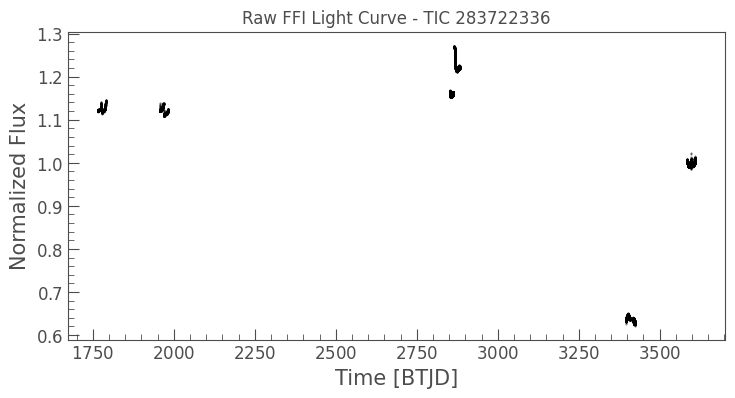


Looking for Transits
Detrending light curve...
  Using known period 3.09d to set window
  Flattening with window = 4009 cadences
  After cleaning: 31321 points
Constrained search: 2.47 - 3.71 days (±20% of 3.09d)

BLS RESULTS:
  Period: 2.9369 days
  Known:  3.0929 days (diff: 5.0%)
  Duration: 7.92 hours
  Depth: 574.1 ppm
  Power: 87495.1
  SNR: 395.5


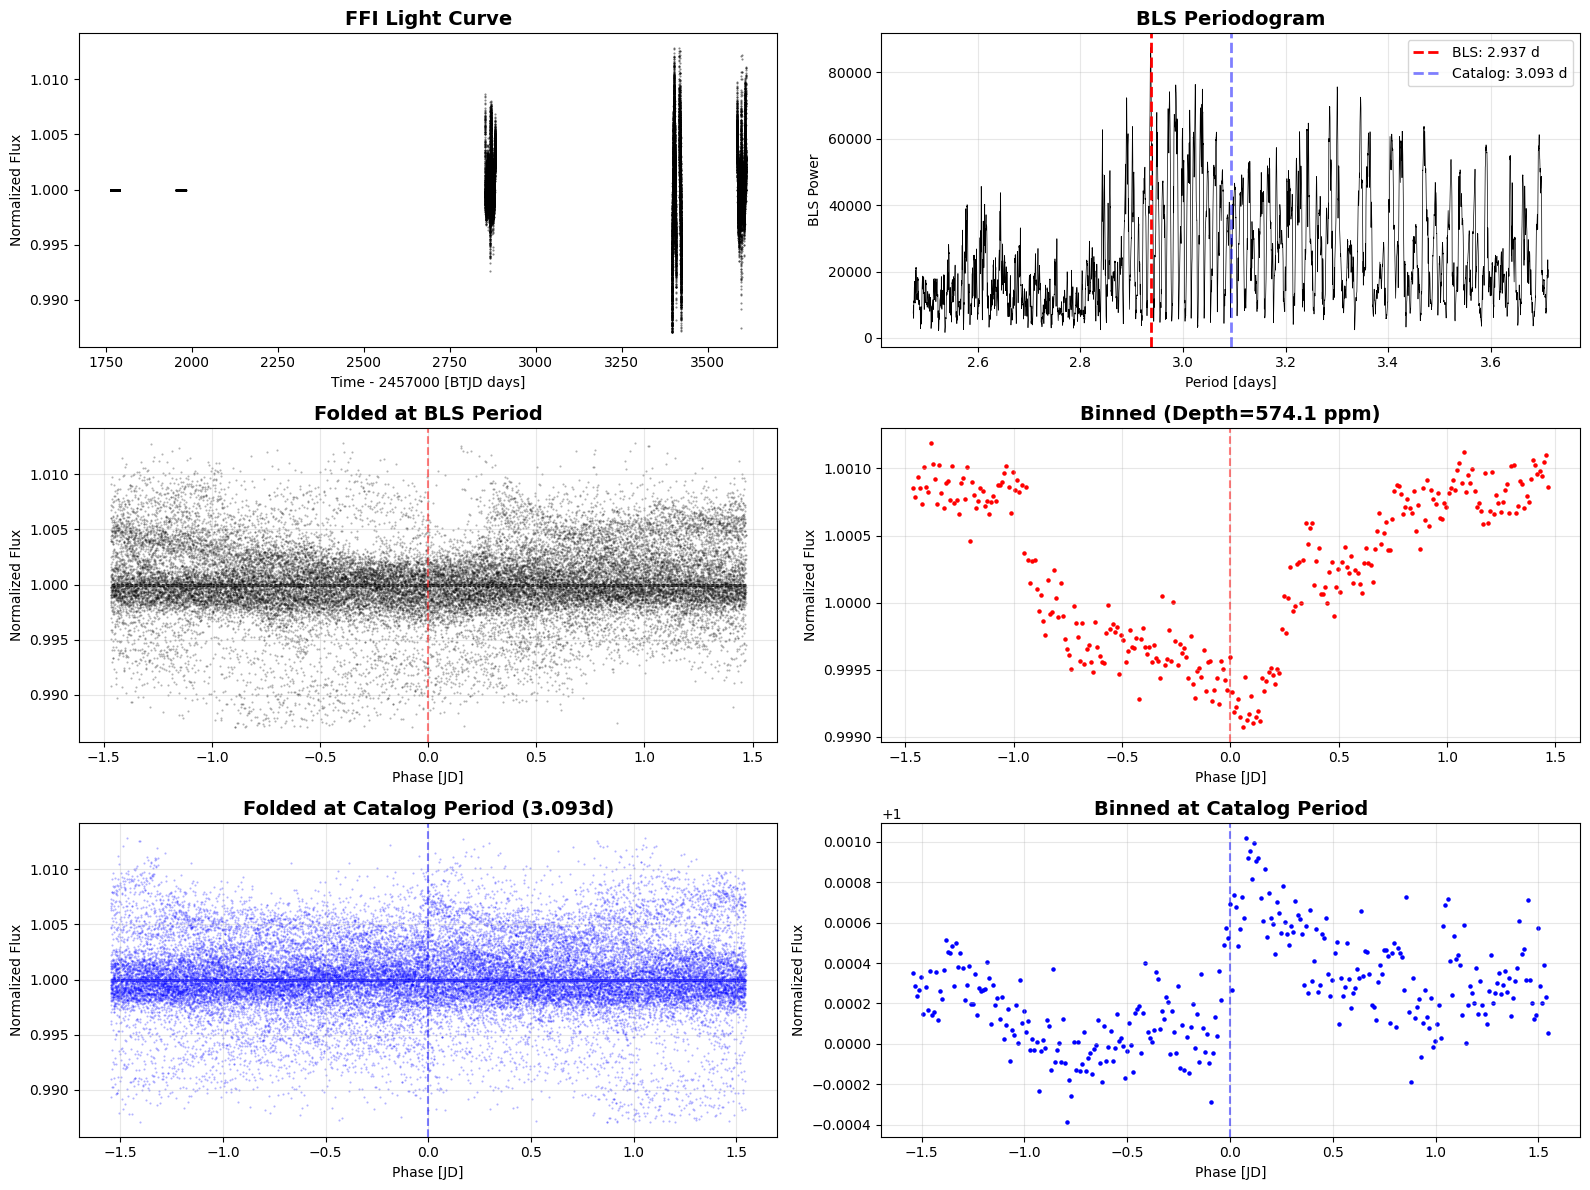


RESULTS:
  Catalog Period: 3.0929 days
  BLS Period: 2.9369 days
  Match: 5.0% difference
  Depth: 574.1 ppm

⚠️ ACCEPTABLE - Small period discrepancy


In [10]:
# Find TOIs with missing params
df_incomplete = search_tois_with_missing_params()

# Pick a good candidate
tic_id = int(df_incomplete['tic_id'].iloc[0])
known_period = float(df_incomplete['pl_orbper'].iloc[0])

print(f"\n{'='*70}")
print(f"Testing TIC {tic_id} (Period: {known_period:.4f} days)")
print(f"{'='*70}")

# Extract FFI light curve with better aperture
lc = extract_lightcurve_from_ffi(tic_id)

if lc is not None:
    # Plot raw light curve first
    plt.figure(figsize=(12, 4))
    lc.scatter(s=1, c='black', alpha=0.5)
    plt.title(f'Raw FFI Light Curve - TIC {tic_id}')
    plt.xlabel('Time [BTJD]')
    plt.ylabel('Normalized Flux')
    plt.show()
    
    # Now search for planets
    results = search_for_planets_in_ffi_constrained(lc, known_period=known_period)
    
    if results is not None:
        period_diff = abs(results['period'] - known_period) / known_period * 100
        print(f"\n{'='*70}")
        print(f"RESULTS:")
        print(f"  Catalog Period: {known_period:.4f} days")
        print(f"  BLS Period: {results['period']:.4f} days")
        print(f"  Match: {period_diff:.1f}% difference")
        print(f"  Depth: {results['depth_ppm']:.1f} ppm")
        print(f"{'='*70}")
        
        if period_diff < 5:
            print("\n✅ GOOD MATCH! Period is accurate")
        elif period_diff < 15:
            print("\n⚠️ ACCEPTABLE - Small period discrepancy")
        else:
            print("\n❌ POOR MATCH - Large period discrepancy")
            print("  Try next candidate or increase cutout_size")

# Only looking at Missing planet radius (not uncertain)

SEARCHING FOR TOIs WITH MISSING PLANET RADIUS

Found 379 TOIs with TRULY MISSING radius!

Top 20 candidates (brightest stars):
    toi     tic_id  pl_orbper  pl_rade  st_tmag tfopwg_disp
1457.01  176860064   6.376817      NaN   7.1145         APC
4391.01   66620917   5.291010      NaN   7.3010          PC
4494.01   40466976  32.535016      NaN   7.3664          PC
1149.01  117789567   2.320242      NaN   7.9172         APC
2183.01 1715469662   6.501126      NaN   8.0348          PC
4175.01  952046774   2.163283      NaN   8.0935          PC
1114.01  409934330   2.488773      NaN   8.1129         APC
2388.01  382625239   1.344272      NaN   8.1150          PC
1986.01  468997317   7.504383      NaN   8.1350         APC
 779.01  374095457   0.783915      NaN   8.2158          PC
 568.01   37575651   9.597198      NaN   8.2866         APC
1531.01  312678993   0.517520      NaN   8.3593         APC
1009.01  107782586   1.960028      NaN   8.4331          PC
1039.01  461867584   4.420125    

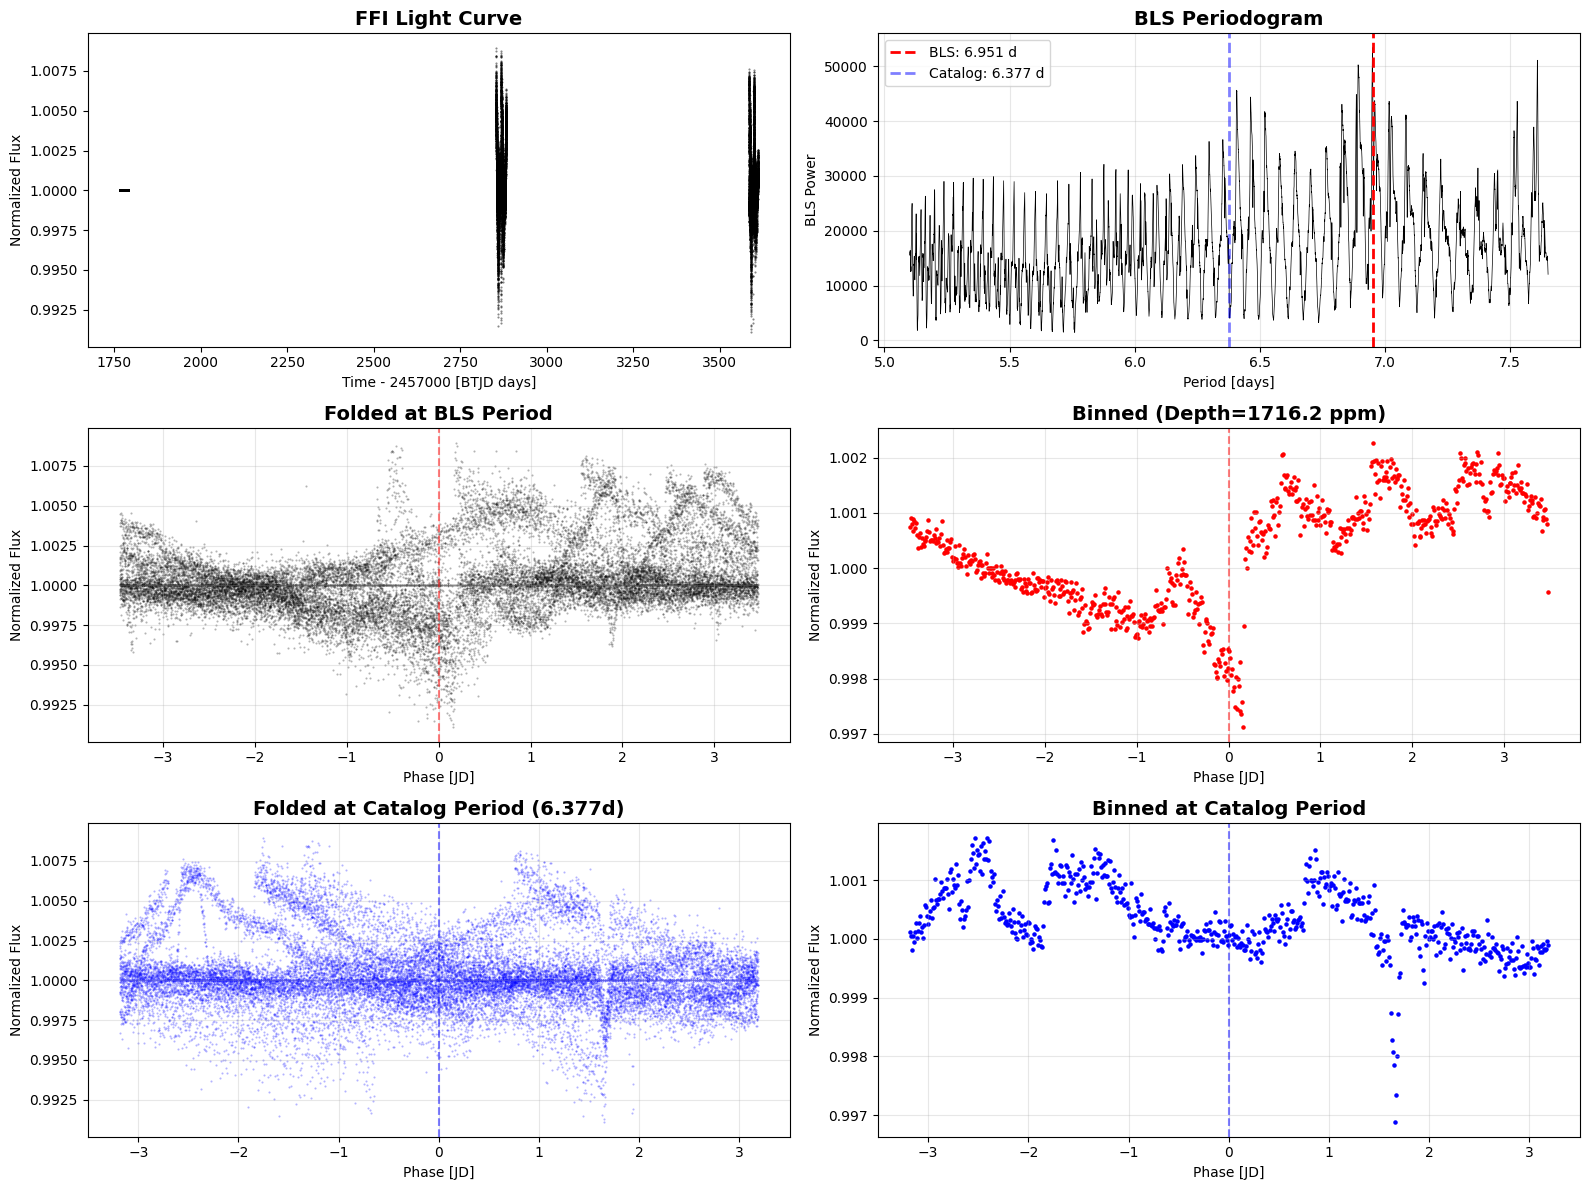


  Transit depth: 1716.2 ppm
  Period: 6.9507 days
  Duration: 7.92 hours


In [12]:
def search_tois_with_truly_missing_params():
    """
    Find TOIs with missing orbital parameters (not just uncertain).
    --> missing radius values.
    """
    print("=" * 20)
    print("SEARCHING FOR TOIs WITH MISSING PLANET RADIUS")
    print("=" * 20)
    
    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_orbpererr1, pl_rade, pl_radeerr1, st_tmag, tfopwg_disp"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid'])
        df['tic_id'] = df['tid'].astype(int)
        
        # STRICT FILTER: Only truly missing radius (NaN)
        missing_params = df[
            # Has period (transit detected)
            (df['pl_orbper'].notna()) &
            # BUT radius is completely MISSING (NaN)
            (df['pl_rade'].isna()) &
            # NOT a false positive
            (~df['tfopwg_disp'].isin(['FP', 'FA'])) if 'tfopwg_disp' in df.columns else True
        ]
        
        # Sort by brightness
        missing_params = missing_params.sort_values('st_tmag')
        
        print(f"\nFound {len(missing_params)} TOIs with TRULY MISSING radius!")
        
        print("\nTop 20 candidates (brightest stars):")
        display_cols = ['toi', 'tic_id', 'pl_orbper', 'pl_rade', 'st_tmag']
        if 'tfopwg_disp' in missing_params.columns:
            display_cols.append('tfopwg_disp')
        
        print(missing_params[display_cols].head(20).to_string(index=False))
        
        return missing_params
        
    except Exception as e:
        print(f"Error: {e}")
        return None


# Run the improved search
df_truly_missing = search_tois_with_truly_missing_params()

if df_truly_missing is not None and len(df_truly_missing) > 0:
    print(f"\n{'='*20}")
    print("ANALYZING FIRST CANDIDATE WITH MISSING RADIUS")  # can change later
    print(f"{'='*20}")
    
    # Pick first one
    tic_id = int(df_truly_missing['tic_id'].iloc[0])
    known_period = float(df_truly_missing['pl_orbper'].iloc[0])
    toi_name = df_truly_missing['toi'].iloc[0]
    tmag = df_truly_missing['st_tmag'].iloc[0]
    
    print(f"\nTOI {toi_name}")
    print(f"  TIC: {tic_id}")
    print(f"  Period: {known_period:.4f} days")
    print(f"  Radius: MISSING")
    print(f"  Tmag: {tmag:.2f}")
    
    # Extract and analyze
    lc = extract_lightcurve_from_ffi(tic_id)
    
    if lc is not None:
        results = search_for_planets_in_ffi_constrained(
            lc, 
            known_period=known_period,
            plot=True
        )
        
        if results is not None:
            print(f"\n{'='*20}")
            print(f"  Transit depth: {results['depth_ppm']:.1f} ppm")
            print(f"  Period: {results['period']:.4f} days")
            print(f"  Duration: {results['duration']*24:.2f} hours")